In [182]:
import pandas as pd
import leafmap.foliumap as leafmap
import seaborn as sns
import matplotlib.pyplot as plt

In [161]:
data = pd.read_csv("cleaned/final.csv")
data.head()

,date,negeri,code,daerah,kawasan_banjir,latitude,longitude,kedalaman_banjir_max,day,month,year,line_check,geometry
0,29/4/2020,Sarawak,SRW,TANGKAK,2. Kg Parit Bengkok,1.5203,103.9244,0.5,29,4,2020,1,POINT (103.9244 1.5203)
1,10/5/2020,Sarawak,SRW,KLUANG,Kg Bentong,2.0475,103.2973,0.5,10,5,2020,1,POINT (103.2973 2.0475)
2,10/5/2020,Sarawak,SRW,KLUANG,Jalan Batu Pahat (Petron Tmn Berlian),2.0173,103.2960,0.5,10,5,2020,1,POINT (103.296 2.0173)
3,10/5/2020,Sarawak,SRW,KLUANG,Taman Intan,2.0147,103.3009,0.5,10,5,2020,1,POINT (103.3009 2.0147)
4,10/5/2020,Sarawak,SRW,KLUANG,Taman Emas,2.0205,103.2986,0.5,10,5,2020,1,POINT (103.2986 2.0205)


In [162]:
df = pd.read_csv("cleaned/rainfall.csv")
df.head()

,nilai_hujan_max,tempoh_hujan,tempoh_ulang,latitude,longitude
0,37.0,1.0,NORMAL,1.5203,103.9244
1,2.0,1.0,NORMAL,2.0475,103.2973
2,65.0,3.0,NORMAL,2.0173,103.2960
3,65.0,3.0,NORMAL,2.0147,103.3009
4,65.0,3.0,NORMAL,2.0205,103.2986


In [163]:
df['kedalaman_banjir'] = data['kedalaman_banjir_max']
len(df)

6955

In [164]:
# get the unique location
df = df.drop_duplicates(subset=['latitude', 'longitude'], keep='first')
len(df)

4805

In [165]:
# reset index after dropping the duplicates
df.reset_index(inplace=True, drop=True)

In [166]:
df['numeric_checker'] = df['tempoh_ulang'].str.isnumeric()

for i in range(0, len(df)):
    if df['numeric_checker'][i] == True:
        df['kedalaman_banjir'][i] = abs(df['kedalaman_banjir'][i])
        pass
    else:
        df['tempoh_ulang'][i] = 2

df['tempoh_ulang'] = df['tempoh_ulang'].astype(int)
df['tempoh_hujan'] = df['tempoh_hujan'].astype(float)

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4805 entries, 0 to 4804
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nilai_hujan_max   4805 non-null   float64
 1   tempoh_hujan      4805 non-null   float64
 2   tempoh_ulang      4805 non-null   int32  
 3   latitude          4805 non-null   float64
 4   longitude         4805 non-null   float64
 5   kedalaman_banjir  4805 non-null   float64
 6   numeric_checker   4805 non-null   bool   
dtypes: bool(1), float64(5), int32(1)
memory usage: 211.3 KB


# Computation of flood risk

In [168]:
# flood hazard based on flood depth
new = [None]*len(df)

for i in range(0, len(df)):
    df['kedalaman_banjir'][i] = abs(df['kedalaman_banjir'][i])
    if (df['kedalaman_banjir'][i] >= 0 and df['kedalaman_banjir'][i] < 0.5):
        new[i] =  "Low"
    elif (df['kedalaman_banjir'][i] >= 0.5 and df['kedalaman_banjir'][i] < 1.2):
        new[i] =  "Medium"
    else:
        new[i] =  "High"

df['flood_hazard'] = new

flood_hazard
Medium    2271
Low       1968
High       566
Name: count, dtype: int64

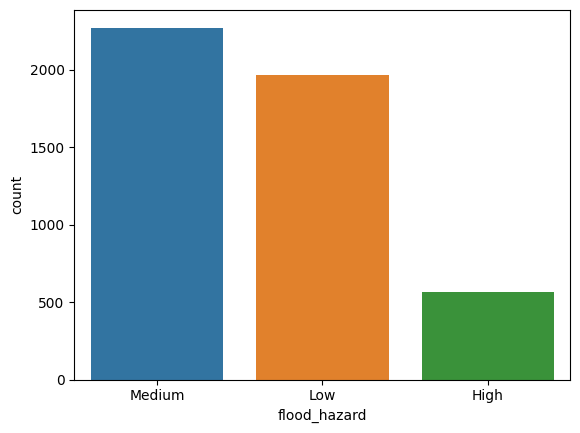

In [169]:
sns.countplot(x='flood_hazard', data=df)
df['flood_hazard'].value_counts()

# Calculate the town distance

In [170]:
# geocode the town column
town_df = pd.read_excel("data/malaysia_towns.xlsx")
town_df.head()

,town,state,Latitude,Longitude
0,Kuala Lumpur,Federal Territories,3.139310,101.682113
1,Kajang,Selangor,2.994844,101.789659
2,Seberang Perai,Penang,5.353882,100.457237
3,Subang Jaya,Selangor,3.051487,101.582334
4,Klang,Selangor,3.083333,101.416667


In [171]:
# compute the distance between two points
import geopandas as gpd

geocoded_data = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude), crs = "EPSG:4326").to_crs('EPSG:3857')
town_data = gpd.GeoDataFrame(town_df, geometry = gpd.points_from_xy(town_df.Longitude, town_df.Latitude), crs = "EPSG:4326").to_crs('EPSG:3857')

# write a function to compute for the minimum distances from any flood point to the nearest town
random_location = geocoded_data.iloc[360]
town_distances = town_data.geometry.distance(random_location.geometry)
town_distances.min()

for i in range(0, len(geocoded_data)):
    town_distances = town_data.geometry.distance(geocoded_data.iloc[i].geometry)
    geocoded_data.loc[i, 'town_distance'] = town_distances.min()

In [172]:
# append the town distance to the dataframe
df['town_distance'] = geocoded_data['town_distance']
df.head()

,nilai_hujan_max,tempoh_hujan,tempoh_ulang,latitude,longitude,kedalaman_banjir,numeric_checker,flood_hazard,town_distance
0,37.0,1.0,2,1.5203,103.9244,0.5,False,Medium,2809.362906
1,2.0,1.0,2,2.0475,103.2973,0.5,False,Medium,2876.993384
2,65.0,3.0,2,2.0173,103.2960,0.5,False,Medium,2862.004618
3,65.0,3.0,2,2.0147,103.3009,0.5,False,Medium,2621.158966
4,65.0,3.0,2,2.0205,103.2986,0.5,False,Medium,2428.517067


In [173]:
df.describe()

,nilai_hujan_max,tempoh_hujan,tempoh_ulang,latitude,longitude,kedalaman_banjir,town_distance
count,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000
mean,107.202560,23.495609,24.182518,3.995630,106.654753,0.688957,30864.853792
std,87.304055,38.622237,92.205614,1.671794,6.279388,0.674845,32723.157195
min,0.000000,0.000000,2.000000,0.905600,99.712200,0.000000,154.498288
25%,47.000000,3.000000,2.000000,2.475200,101.481600,0.300000,7576.643379
50%,83.000000,4.000000,2.000000,3.912900,102.560900,0.500000,18123.755388
75%,145.000000,30.000000,8.000000,5.490500,112.609900,0.900000,42483.753453
max,570.000000,288.000000,2574.000000,7.024400,118.421800,9.000000,281668.241554


## Calculate the strata value

In [174]:
# calculate the damage factors
new = [None]*len(df)

for i in range(0, len(df)):
    if (df['town_distance'][i] < 15000):
        new[i] = 1
    else:
        new[i] = 0

df['strata'] = new
df.head()

,nilai_hujan_max,tempoh_hujan,tempoh_ulang,latitude,longitude,kedalaman_banjir,numeric_checker,flood_hazard,town_distance,strata
0,37.0,1.0,2,1.5203,103.9244,0.5,False,Medium,2809.362906,1
1,2.0,1.0,2,2.0475,103.2973,0.5,False,Medium,2876.993384,1
2,65.0,3.0,2,2.0173,103.2960,0.5,False,Medium,2862.004618,1
3,65.0,3.0,2,2.0147,103.3009,0.5,False,Medium,2621.158966,1
4,65.0,3.0,2,2.0205,103.2986,0.5,False,Medium,2428.517067,1


# Calculate the damage factor
Using the data from Condition of Flooding and Flood Damage Assessment, JPS (2012) for residential household, 
- mean damange = 3274
- mean stata value = 0.25 (urban = 1 and rural = 0)
- mean depth = 0.93
- mean duration = 2.83

Total damage factor = 0.32 * (depth - mean_depth) +
                0.08 * (duration - mean_duration) +
                0.33 * (strata - mean_strata) +
                1

We are using the formula proposed by (Sabri, Ratnarajah, Adnan, Wan Hazdy Azad, & Mohd Fisham, 2018) which the paper could not be found 🤔
The formula is as follows: `R = sum( 1/i*D)` where

- `R` is the flood risk
- `i` is the ARI
- `D` is the damage factor for each ARI

Procedure:
1. Find the damage factor for each ARI
2. Multiply the damage factor to the inverse of ARI for each ARI

Pixels assumption:
1. 100m x 100m or 1 hectare per pixel
2. Assume for each location is the center of a square of length 1500m x 1500m that gives us 225 pixels
3. We will perform 25 iterative sum for the term `1/i*D`

_________________
|               |
|               |
|        *      |
|               |
|_______________|

In [175]:
# Computing the damage
# assume all locations are in fact residential areas

new = [None]*len(df)

# define variables
mean_depth = 0.93
mean_duration = 2.83
mean_strata = 0.25

# we have to compute for each unit, we need to find how many houses in a taman of the size that we defined (about 15 hectares)
# assume for one housing unit, it is about 1 hectare, so we assume there are 15 houses in a taman

for i in range(0, len(df)):
    new[i] = 0.32 * (df['kedalaman_banjir'][i] - mean_depth) + 0.08 * (df['tempoh_hujan'][i] - mean_duration) + 0.33 * (df['strata'][i] - mean_strata) + 1 
    for j in range(0,14):
        new[i] = new[i] + 0.32 * (df['kedalaman_banjir'][i] - mean_depth) + 0.08 * (df['tempoh_hujan'][i] - mean_duration) + 0.33 * (df['strata'][i] - mean_strata) + 1 
    
df['damage_factor'] = new
df.head()

,nilai_hujan_max,tempoh_hujan,tempoh_ulang,latitude,longitude,kedalaman_banjir,numeric_checker,flood_hazard,town_distance,strata,damage_factor
0,37.0,1.0,2,1.5203,103.9244,0.5,False,Medium,2809.362906,1,14.4525
1,2.0,1.0,2,2.0475,103.2973,0.5,False,Medium,2876.993384,1,14.4525
2,65.0,3.0,2,2.0173,103.2960,0.5,False,Medium,2862.004618,1,16.8525
3,65.0,3.0,2,2.0147,103.3009,0.5,False,Medium,2621.158966,1,16.8525
4,65.0,3.0,2,2.0205,103.2986,0.5,False,Medium,2428.517067,1,16.8525


<Axes: xlabel='damage_factor', ylabel='Density'>

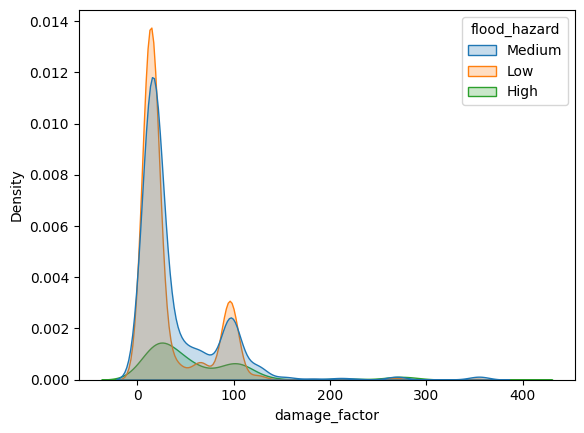

In [176]:
sns.kdeplot(data=df, x="damage_factor", hue="flood_hazard", fill = True)

In [177]:
new = [None]*len(df)

for i in range(0, len(df)):
    new[i] = 1/df['tempoh_ulang'][i]*df['damage_factor'][i]
    for j in range(0,224):
        new[i] = new[i] + 1/df['tempoh_ulang'][i]*df['damage_factor'][i]
        
df['flood_risk'] = new

<Axes: xlabel='flood_risk', ylabel='Density'>

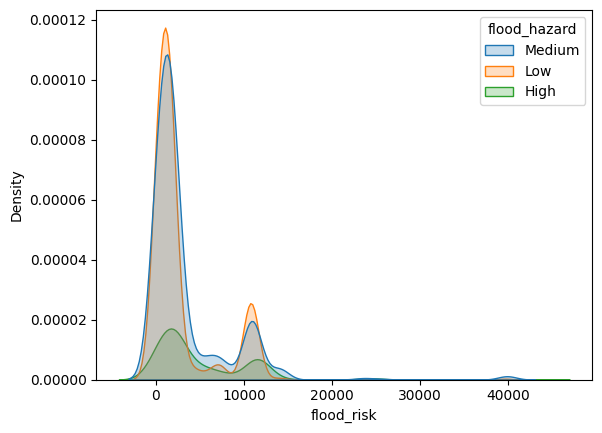

In [178]:
sns.kdeplot(data=df, x="flood_risk", hue="flood_hazard", fill = True)

In [179]:
df['flood_risk'].describe()

count     4805.000000
mean      3220.442664
std       4524.201422
min          2.626967
25%        615.515625
50%       1604.981250
75%       2684.306250
max      42784.031250
Name: flood_risk, dtype: float64

In [180]:
# compute the flood risk class
new = [None]*len(df)

for i in range(0, len(df)):
    if df['flood_risk'][i] <= 50:
        new[i] = 'Very Low'
    elif df['flood_risk'][i] > 50 and df['flood_risk'][i] <= 1000:
        new[i] = 'Low'
    elif df['flood_risk'][i] > 1000 and df['flood_risk'][i] <= 5000:
        new[i] = 'Medium'
    elif df['flood_risk'][i] > 5000 and df['flood_risk'][i] <= 25000:
        new[i] = 'High'
    else:
        new[i] = 'Very High'
        
df['flood_risk_class'] = new

flood_risk_class
Medium       2329
Low          1252
High          966
Very Low      237
Very High      21
Name: count, dtype: int64

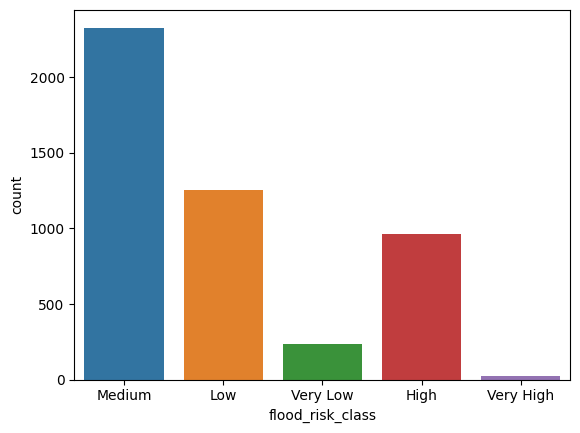

In [181]:
sns.countplot(x='flood_risk_class', data=df)
df['flood_risk_class'].value_counts()

# Map Visualization

In [202]:
m = leafmap.Map(google_map = "HYBRID", center=[3.1390, 104.6869], zoom=6)

data = "data/countries.geojson"

m.add_geojson(data, layer_name="Countries")
m.add_heatmap(df, latitude="latitude", longitude='longitude', value="flood_risk", name="Heat map", radius=20)
m